# Density estimation

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
SQRT_2_PI = np.sqrt(2 * np.pi)

def normal(x, mu, sigma):
    sigma_2 = sigma * sigma
    return np.exp(-(x - mu)**2 / (2*sigma_2)) / (SQRT_2_PI * sigma)

sample_ns = [10, 100, 1000, 10000]


x_grid = np.linspace(-5, 5, 1000)
y_true = normal(x_grid, 0 , 1)

## Non-parametric way

The easiest way to estimate distribution density is to build a histogram. It can be simply implemented and quickly computed, but requires a sufficient number of points and density function is not smooth.

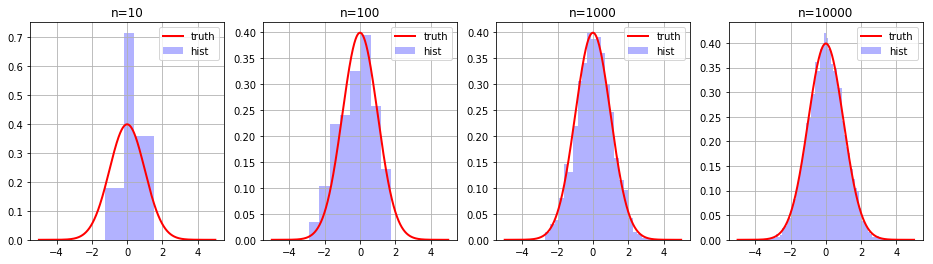

In [3]:
plt.figure(figsize=(16, 4))
for i, sample_n in enumerate(sample_ns, 1):
    X = np.random.randn(sample_n)
    plt.subplot(1, len(sample_ns), i)
    plt.title(f'n={sample_n}')
    plt.hist(X, bins='auto', normed=True, color='blue', alpha=0.3, label='hist')
    plt.plot(x_grid, y_true, color='red', linewidth=2, label='truth')
    plt.grid()
    plt.legend()

On the other hand, it is possible to estimate the density of distribution with kernel smoothing. You can read more [here](https://en.wikipedia.org/wiki/Kernel_density_estimation). Unfortunately, this approach requires more calculations.

Let there are samples $\{x_{i}\}_{i=1}^{n}$, it's possible to estimate density at point $x$ with window $h$ as 

$$\widehat{f}_h(x) = \frac{1}{nh} \sum_{i=1}^n K\Big(\frac{x-x_i}{h}\Big),$$

where $K$ – some [kernel function](https://en.wikipedia.org/wiki/Kernel_(statistics)).

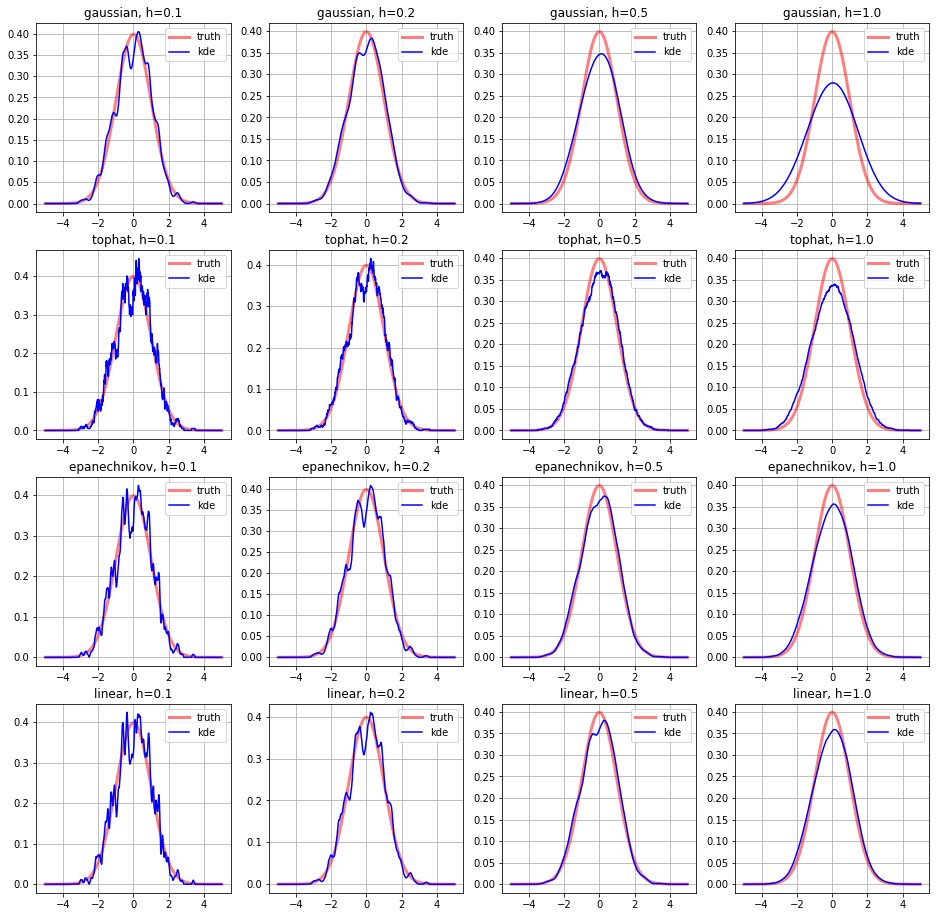

In [4]:
def kde(X_train, X_test, kernel, h):
    density = KernelDensity(bandwidth=h, kernel=kernel)
    density.fit(X_train.reshape(-1, 1))
    return np.exp(
        density.score_samples(X_test.reshape(-1, 1))
    )
                     

kernels = ['gaussian', 'tophat', 'epanechnikov', 'linear']
H = [0.1, 0.2, 0.5, 1.0]
    
X = np.sort(np.random.randn(1000))

plt.figure(figsize=(16, 16))
for i, kernel in enumerate(kernels):
    for j, h in enumerate(H):
        plt.subplot(len(kernels), len(H), i * len(H) + j + 1)
        plt.title(f'{kernel}, h={h}')
        plt.plot(x_grid, y_true, linewidth=3, label='truth', alpha=0.5, color='red')
        plt.plot(x_grid, kde(X, x_grid, kernel, h), color='blue', label='kde')
        plt.grid()
        plt.legend()

## Parametric way

There is a parametric estimation of the distribution. This problem is reduced to maximizing [logarithm of likelihood](https://en.wikipedia.org/wiki/Likelihood_function)

$$\arg\max_{\theta} \sum_{i} \log f(x_{i}|\theta).$$

For example for normal distribution parameters $\mu$ and $\sigma$ can be estimated as $\mu = \sum_{i}x_i$ and $\sigma^2 = \sum_{i} (x_i - \mu)^2$.

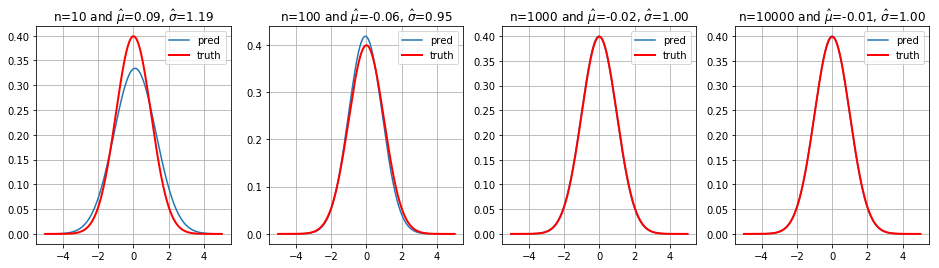

In [5]:
plt.figure(figsize=(16, 4))
for i, sample_n in enumerate(sample_ns, 1):
    X = np.random.randn(sample_n)
    plt.subplot(1, len(sample_ns), i)
    
    mu = X.mean()
    sigma = X.std()
    
    plt.title(f'n={sample_n} and $\hat\mu$={mu:.2f}, $\hat\sigma$={sigma:.2f}')
    
    plt.plot(x_grid, normal(x_grid, mu, sigma), label='pred')
    plt.plot(x_grid, y_true, color='red', linewidth=2, label='truth')
    plt.grid()
    plt.legend()

In case where the distribution is a [mixture of several ones](https://en.wikipedia.org/wiki/Mixture_model), you can already use [EM-algorithm](https://en.wikipedia.org/wiki/Expectation–maximization_algorithm).

In [6]:
mu_one = np.array([-1, -1])
mu_two = np.array([2, 2])

V = np.array([[1., 0.],[0., 1.]])

X_one = np.random.multivariate_normal(mu_one, V, 300)
X_two = np.random.multivariate_normal(mu_two, V, 100)


X = np.vstack([X_one, X_two])

In [7]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1.0, x.max() + 1.0
    y_min, y_max = y.min() - 1.0, y.max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_gaussian(X, mean, cov, color, labels=False):    
    xx, yy = make_meshgrid(X[:, 0], X[:, 1])
    
    z = sc.stats.multivariate_normal.pdf(np.vstack([xx.ravel(), yy.ravel()]).T, mean=mean, cov=cov)
    z = z.reshape(xx.shape)
    contour = plt.contour(xx, yy, z, colors=[color], linestyles=[':'], linewodth=5)
    
    if labels:
        plt.clabel(contour, inline=True, fontsize=10)

Example for mixture of two gaussian. Plot EM-algorithm step by step.

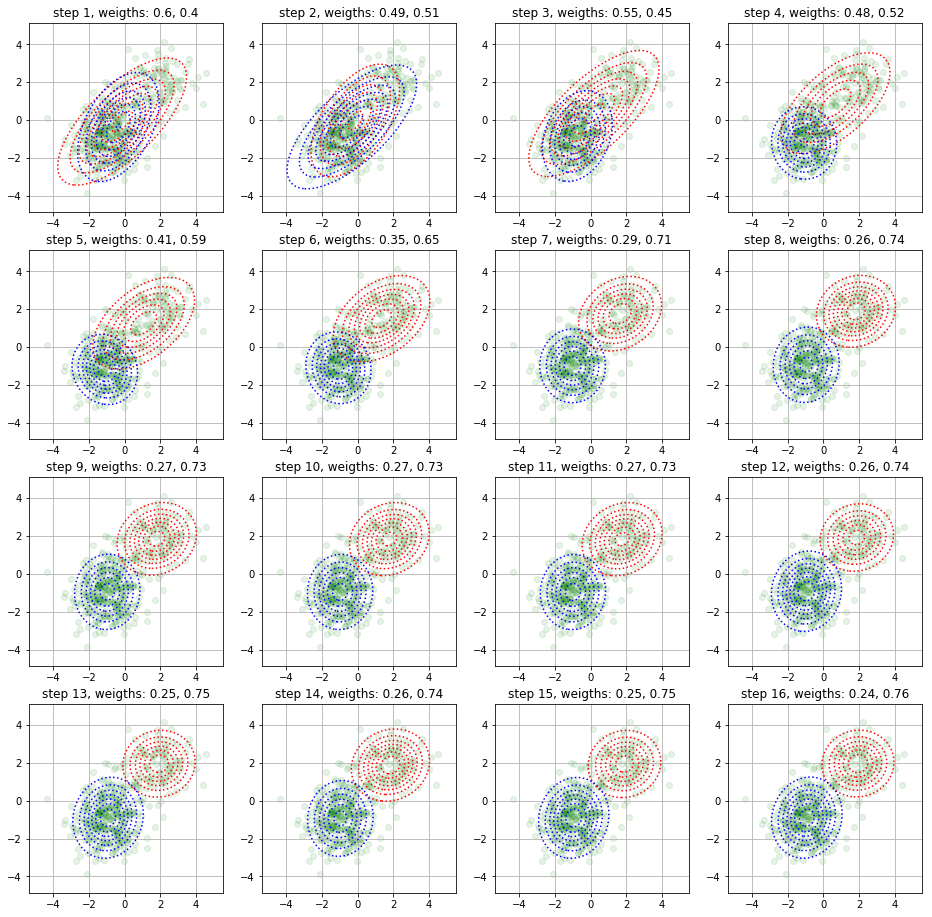

In [8]:
weights = np.array([0.5, 0.5])
means = np.zeros([2, 2])
covs = np.array([np.eye(2)]*2)

H, W = 4, 4


plt.figure(figsize=(16, 16))
for i in range(H*W):
    gmm = GaussianMixture(
        n_components=2,
        max_iter=1,
        weights_init = weights,
        means_init = means
        
    )
    gmm.fit(X)

    weights = gmm.weights_
    means = gmm.means_
    covs = gmm.covariances_

    plt.subplot(H, W, i + 1)
    plt.title(f'step {i + 1}, weigths: {weights[0]:.2}, {weights[1]:.2}')
    plt.scatter(X[:, 0], X[:, 1], color='green', alpha=0.1)
    plot_gaussian(X, gmm.means_[0], gmm.covariances_[0], color='red')
    plot_gaussian(X, gmm.means_[1], gmm.covariances_[1], color='blue')
    plt.grid()

## Naive Bayes classifier

We will have only two classes whose functions are distributed normally and independently.

In [9]:
mu_red = np.array([-1, -1])
mu_blue = np.array([2, 2])

sigma_red = np.array([[1., 0.],[0., 1.]])
sigma_blue = np.array([[3., 0.],[0., 2.]])

X_red = np.random.multivariate_normal(mu_red, sigma_red, 200)
X_blue = np.random.multivariate_normal(mu_blue, sigma_blue, 300)

X = np.vstack([X_red, X_blue])

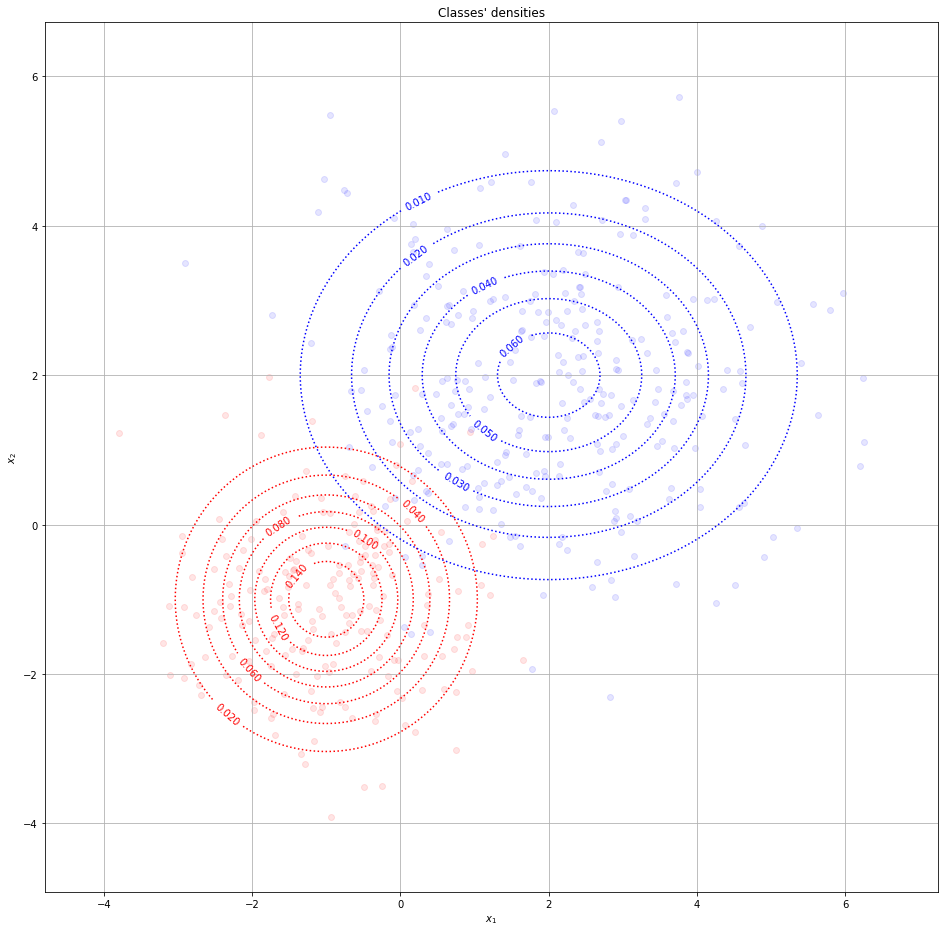

In [10]:
plt.figure(figsize=(16, 16))

plt.title('Classes\' densities')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plot_gaussian(X, mu_red, sigma_red, 'red', labels=True)
plot_gaussian(X, mu_blue, sigma_blue, 'blue', labels=True)

plt.scatter(X_red[:, 0], X_red[:, 1], color='red', alpha=0.1)
plt.scatter(X_blue[:, 0], X_blue[:, 1], color='blue', alpha=0.1)

plt.grid()

It means that possible to use [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) and estimate densities in parametric way.

$$a(x) = \arg\max_{y} p(y)p(x|y)$$

$$p(x|y) = \frac{\exp\left(-\frac{1}{2} (x - \mu_y)^\mathrm{T}{\Sigma_y}^{-1}(x - \mu_y)\right)}{\sqrt{(2\pi)^k \det \Sigma_y}} $$

In [11]:
def bivariate_normal(x, mu, sigma):
    x_norm = x - mu
     
    sigma_inv = np.linalg.inv(sigma)
    sigma_det = np.linalg.det(sigma)

    first_mul = x_norm @ sigma_inv
    second_mul = first_mul.reshape(-1, 1, 2) @ x_norm.reshape(-1, 2, 1)
    numerator = np.exp(-second_mul.reshape(-1))
    
    return numerator / (2 * np.pi * np.sqrt(sigma_det))

In [12]:
n_red = len(X_red)
n_blue = len(X_blue)

n = n_red + n_blue

red_prob = n_red / n
blue_prob = n_blue / n

mu_red_hat = X_red.mean(axis=0)
mu_blue_hat = X_blue.mean(axis=0)

sigma_red_hat = np.array(
    [[X_red[:, 0].std(), 0],
     [0, X_red[:, 1].std()]]
)
sigma_blue_hat = np.array(
    [[X_blue[:, 0].std(), 0],
     [0, X_blue[:, 1].std()]]
)

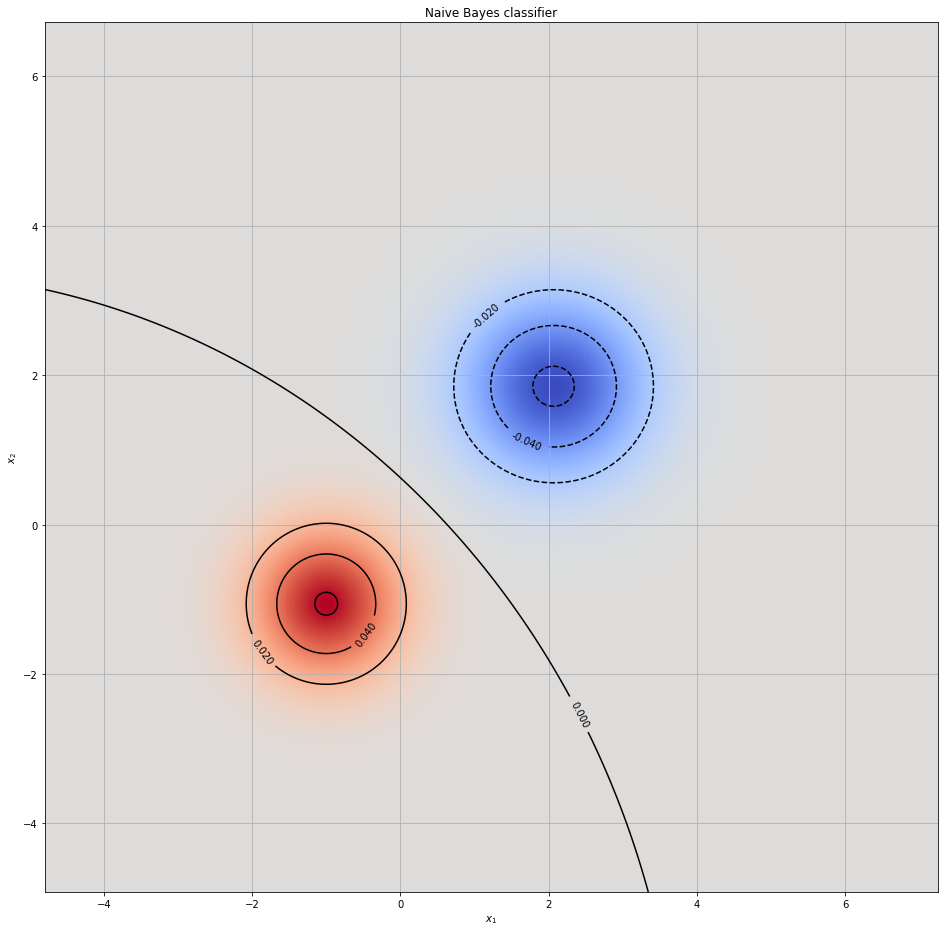

In [13]:
plt.figure(figsize=(16, 16))

plt.title('Naive Bayes classifier')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

xx, yy = make_meshgrid(X[:, 0], X[:, 1])
xy = np.vstack([xx.ravel(), yy.ravel()]).T


z = red_prob * bivariate_normal(xy, mu_red_hat, sigma_red_hat) - \
        blue_prob * bivariate_normal(xy, mu_blue_hat, sigma_blue_hat)

z = z.reshape(xx.shape)

plt.pcolormesh(xx, yy, z, cmap=plt.cm.coolwarm)
contour = plt.contour(xx, yy, z, colors=['black'])
plt.clabel(contour, inline=True, fontsize=10)



plt.grid()